In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import plotly.express as px
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [2]:
file_path = "air_bnb.csv"
df = pd.read_csv(file_path)

df.head(), df.info(), df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              22552 non-null  int64  
 1   name                            22493 non-null  object 
 2   host_id                         22552 non-null  int64  
 3   host_name                       22526 non-null  object 
 4   neighbourhood_group             22552 non-null  object 
 5   neighbourhood                   22552 non-null  object 
 6   latitude                        22552 non-null  float64
 7   longitude                       22552 non-null  float64
 8   room_type                       22552 non-null  object 
 9   price                           22552 non-null  int64  
 10  minimum_nights                  22552 non-null  int64  
 11  number_of_reviews               22552 non-null  int64  
 12  last_review                     

(     id                                              name  host_id host_name  \
 0  2015  Berlin-Mitte Value! Quiet courtyard/very central     2217       Ian   
 1  2695                Prenzlauer Berg close to Mauerpark     2986   Michael   
 2  3176                   Fabulous Flat in great Location     3718    Britta   
 3  3309                 BerlinSpot Schöneberg near KaDeWe     4108      Jana   
 4  7071                  BrightRoom with sunny greenview!    17391    Bright   
 
       neighbourhood_group             neighbourhood   latitude  longitude  \
 0                   Mitte           Brunnenstr. Süd  52.534537  13.402557   
 1                  Pankow  Prenzlauer Berg Nordwest  52.548513  13.404553   
 2                  Pankow   Prenzlauer Berg Südwest  52.534996  13.417579   
 3  Tempelhof - Schöneberg           Schöneberg-Nord  52.498855  13.349065   
 4                  Pankow            Helmholtzplatz  52.543157  13.415091   
 
          room_type  price  minimum_nights

In [3]:
print("Missing Values:\n", df.isnull().sum())
print("Room Type Distribution:\n", df["room_type"].value_counts())
print("Price Description:\n", df["price"].describe())

Missing Values:
 id                                   0
name                                59
host_id                              0
host_name                           26
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3908
reviews_per_month                 3914
calculated_host_listings_count       0
availability_365                     0
dtype: int64
Room Type Distribution:
 Private room       11534
Entire home/apt    10722
Shared room          296
Name: room_type, dtype: int64
Price Description:
 count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: 

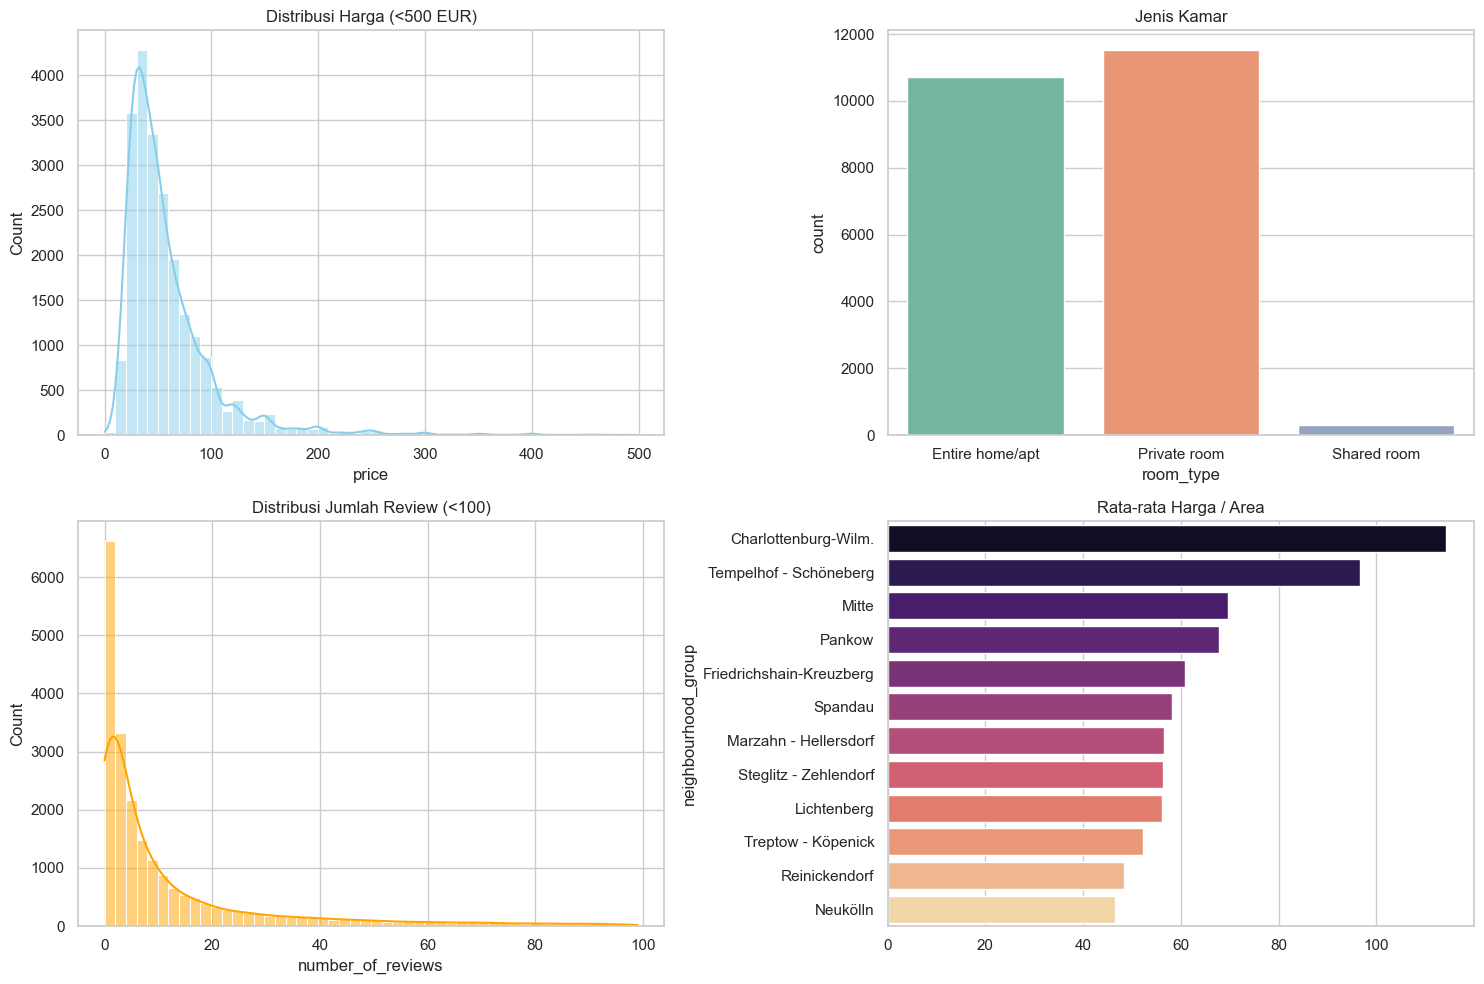

In [4]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(df[df['price'] < 500]['price'], bins=50, ax=axs[0, 0], kde=True, color='skyblue')
axs[0, 0].set_title("Distribusi Harga (<500 EUR)")

sns.countplot(x='room_type', data=df, ax=axs[0, 1], palette='Set2')
axs[0, 1].set_title("Jenis Kamar")

sns.histplot(df[df['number_of_reviews'] < 100]['number_of_reviews'], bins=50, ax=axs[1, 0], color='orange', kde=True)
axs[1, 0].set_title("Distribusi Jumlah Review (<100)")

avg_price = df.groupby("neighbourhood_group")["price"].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.values, y=avg_price.index, ax=axs[1, 1], palette="magma")
axs[1, 1].set_title("Rata-rata Harga / Area")

plt.tight_layout()
plt.show()

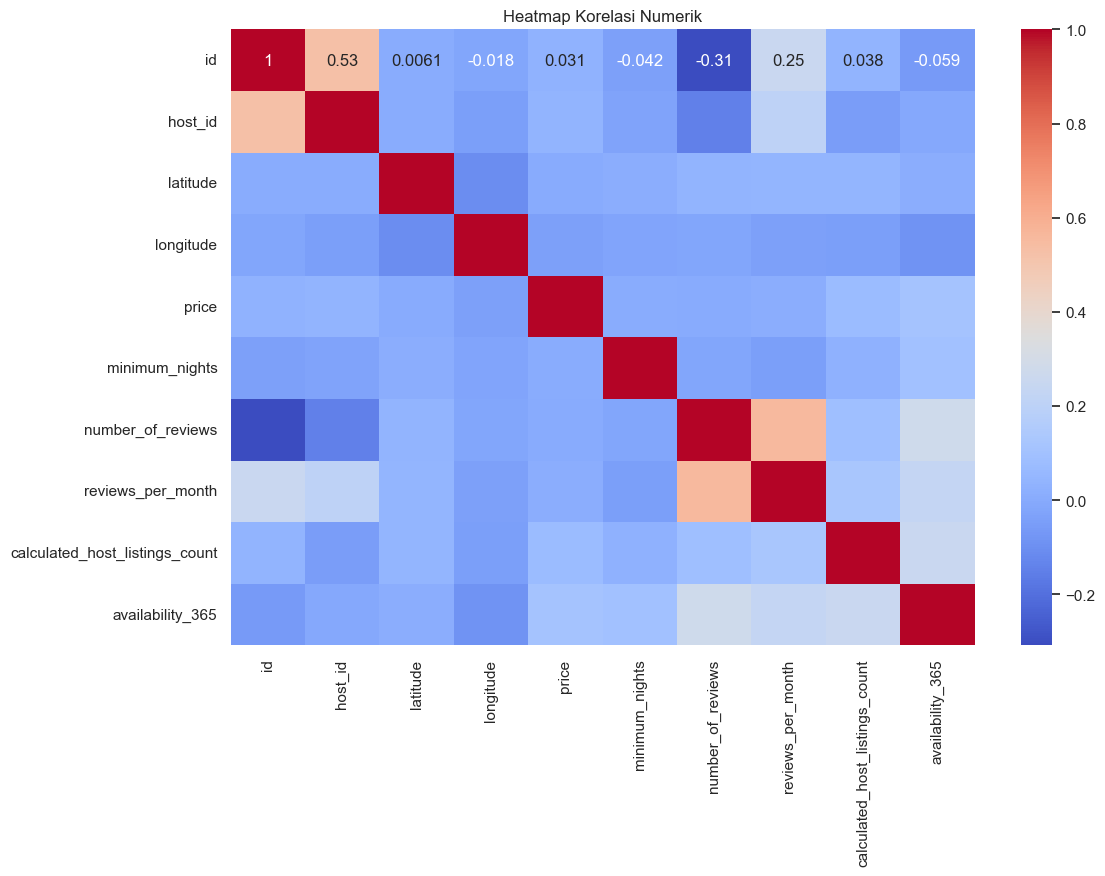

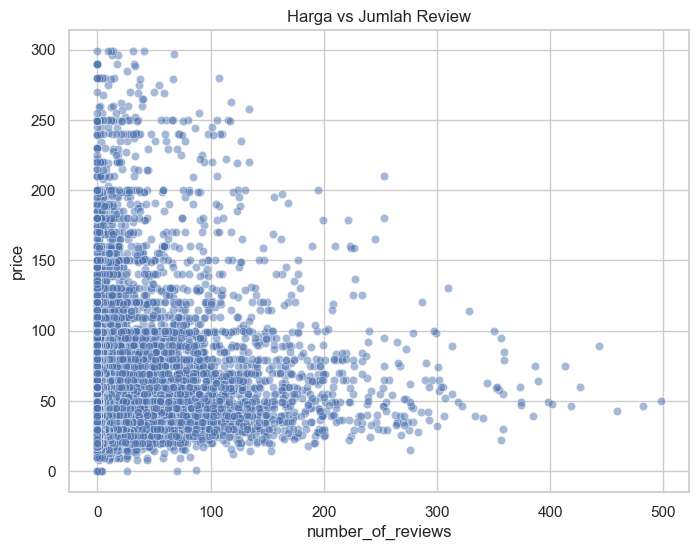

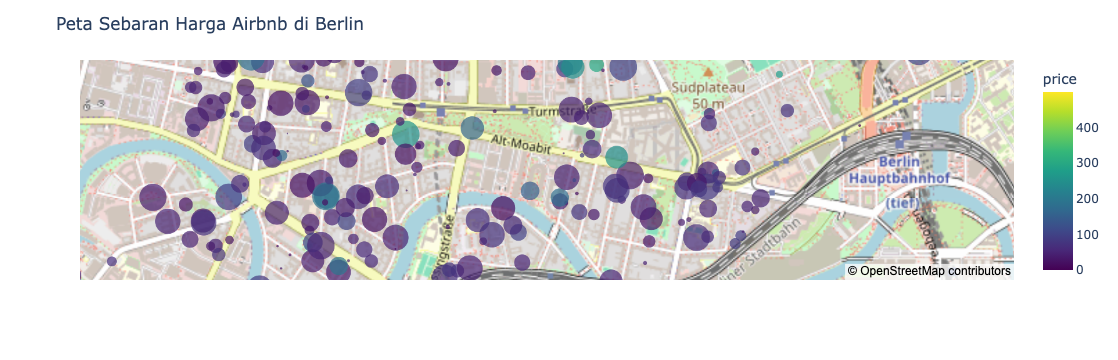

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Numerik")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['price'] < 300], x='number_of_reviews', y='price', alpha=0.5)
plt.title("Harga vs Jumlah Review")
plt.show()

fig = px.scatter_mapbox(df[df['price'] < 500], 
                        lat="latitude", lon="longitude", 
                        color="price", size="availability_365",
                        color_continuous_scale="Viridis",
                        mapbox_style="open-street-map", zoom=10)
fig.update_layout(title="Peta Sebaran Harga Airbnb di Berlin")
fig.show()

In [6]:
df = df.drop(columns=["id", "name", "host_id", "host_name", "last_review"])
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)
df = df[(df["price"] > 0) & (df["price"] < 500)]
df = df[df["minimum_nights"] <= 60]

df["log_price"] = np.log1p(df["price"])
df["long_term"] = (df["minimum_nights"] > 30).astype(int)
df["high_availability"] = (df["availability_365"] > 200).astype(int)
df["review_density"] = df["reviews_per_month"] / df["calculated_host_listings_count"]


df = pd.get_dummies(df, columns=["neighbourhood_group", "neighbourhood", "room_type"], drop_first=True)

In [7]:
X = df.drop(columns=["price", "log_price"])
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = np.expm1(rf.predict(X_test_scaled))
rf_actual = np.expm1(y_test)

print("\n📊 Evaluasi Random Forest:")
print("MAE:", mean_absolute_error(rf_actual, rf_pred))
print("RMSE:", np.sqrt(mean_squared_error(rf_actual, rf_pred)))
print("R2:", r2_score(rf_actual, rf_pred))


📊 Evaluasi Random Forest:
MAE: 18.823662845337214
RMSE: 33.02665355020505
R2: 0.35815485536925196


In [9]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train)
gb_pred = np.expm1(gb.predict(X_test_scaled))

print("\n📊 Evaluasi Gradient Boosting:")
print("MAE:", mean_absolute_error(rf_actual, gb_pred))
print("RMSE:", np.sqrt(mean_squared_error(rf_actual, gb_pred)))
print("R2:", r2_score(rf_actual, gb_pred))



📊 Evaluasi Gradient Boosting:
MAE: 18.71246739143494
RMSE: 33.48381325569928
R2: 0.340262848384806


In [10]:
df["price_class"] = pd.cut(df["price"], bins=[0, 50, 100, 500], labels=["Murah", "Sedang", "Mahal"])

X_class = df.drop(columns=["price", "log_price", "price_class"])
y_class = df["price_class"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_c)
y_test_enc = le.transform(y_test_c)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_c_scaled, y_train_enc)

clf = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
clf.fit(X_train_sm, y_train_sm)

y_pred_enc = clf.predict(X_test_c_scaled)

y_pred_label = le.inverse_transform(y_pred_enc)
y_test_label = le.inverse_transform(y_test_enc)

print("\n📊 Evaluasi XGBoost Klasifikasi:")
print("Accuracy:", accuracy_score(y_test_label, y_pred_label))
print("Classification Report:\n", classification_report(y_test_label, y_pred_label))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[08:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





📊 Evaluasi XGBoost Klasifikasi:
Accuracy: 0.6975687343785504
Classification Report:
               precision    recall  f1-score   support

       Mahal       0.38      0.39      0.38       379
       Murah       0.82      0.81      0.82      2618
      Sedang       0.56      0.57      0.56      1404

    accuracy                           0.70      4401
   macro avg       0.59      0.59      0.59      4401
weighted avg       0.70      0.70      0.70      4401

